<h1>Naive Bayes Classifier</h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix

Reading the data set

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['top genre', 'title'], axis=1, inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
0,Train,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
1,Eminem,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
2,Kesha,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
3,Lady Gaga,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
4,Bruno Mars,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


Because the Naive Bayes cannot work with categorical features expressed as string values, we need to use LabelEncoder to encode them to integer values. I am not using OneHotEncoding since the number of possible categories for artist is large. <br>
Additionally, scaling is not critical for the algorithm so it is not performed.

In [ ]:
data = data.apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
0,200,87,19,0,37,110,54,51,11,111,95,44,11,58,0
1,58,205,36,0,21,114,72,41,86,82,150,55,61,57,0
2,103,117,23,0,77,103,75,62,60,96,66,27,47,55,1
3,108,172,31,0,76,113,61,51,11,96,174,0,11,54,1
4,26,193,34,0,54,103,50,41,19,48,99,10,11,53,0


Split the data into train and test set with 80% - 20% proportions

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data.drop(['is_dance_pop'], axis=1),
    data['is_dance_pop'],
    test_size = 0.2,
    random_state = 0
)

Let's try with the default classifier and without inspecting variable correlations.

In [ ]:
nb_classifier = GaussianNB()

In [ ]:
nb_classifier.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_predicted_default = nb_classifier.predict(X_test)

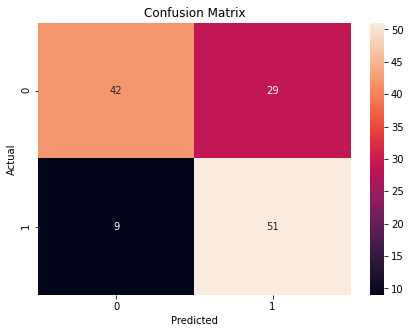

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, y_predicted_default), annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the confusion matrix, we can see that the classifier is biased towards predicting a positive class label. Maybe adding a prior for a fair distribution can fix this, or removing correlated features.

A less biased approach would be to try cross-validation. Let's try this next.


Cross validation

In [ ]:
def cross_validation_nb(X, Y, clf):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    clf.fit(X_train, Y_train)
    predicted_vals = clf.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(clf, X, Y)

  return predicted, actual, score

In [ ]:
predicted, actual, score_cv = cross_validation_nb(data.drop(['is_dance_pop'], axis=1), data['is_dance_pop'], nb_classifier)

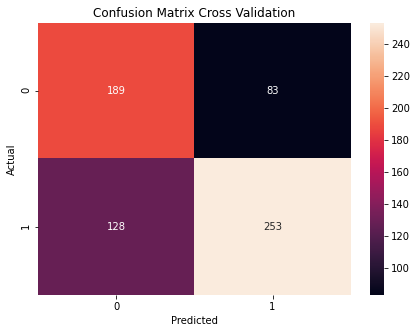

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted, actual), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix on the full data set, from the cross validation predictions shows a different situation. This time the model predicts 0 more often. 

In [ ]:
score_cv

array([0.53435115, 0.70229008, 0.72519084, 0.7       , 0.69230769])

On the first fold of 5 total, the model performs a bit worse than on the other folds.

Scores from the 5 folds of cross-validation

In [ ]:
score_cv.mean()

0.670827950675279

The mean cross validation score is approximately 0.67. Let's check the other metrics.

<h3>Evaluating the base model for heldout and cross-validation method</h3>

In [ ]:
f1_heldout = f1_score(Y_test, y_predicted_default)
accuracy_heldout = accuracy_score(Y_test, y_predicted_default)
precision_heldout = precision_score(Y_test, y_predicted_default)
recall_heldout = recall_score(Y_test, y_predicted_default)
######
f1_cv = f1_score(actual, predicted)
accuracy_cv = accuracy_score(actual, predicted)
precision_cv = precision_score(actual, predicted)
recall_cv = recall_score(actual, predicted)

In [ ]:
print(f'F1_score heldout: {f1_heldout}')
print(f'Accuracy heldout: {accuracy_heldout}')
print(f'Precision heldout: {precision_heldout}')
print(f'Recall heldout: {recall_heldout}')
print('------------------------------------')
print(f'F1_score cv: {f1_cv}')
print(f'Accuracy cv: {accuracy_cv}')
print(f'Precision cv: {precision_cv}')
print(f'Recall cv: {recall_cv}')

F1_score heldout: 0.7285714285714286
Accuracy heldout: 0.7099236641221374
Precision heldout: 0.6375
Recall heldout: 0.85
------------------------------------
F1_score cv: 0.705718270571827
Accuracy cv: 0.6768759571209801
Precision cv: 0.6640419947506562
Recall cv: 0.7529761904761905


In [ ]:
def draw_figure_metrics(f1_h, acc_h, rec_h, prec_h, f1_cv, acc_cv, rec_cv, prec_cv, graph_name='base model'):
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plt.bar(1, acc_h)
  plt.bar(2, rec_h)
  plt.bar(3, prec_h)
  plt.bar(4, f1_h)
  plt.xticks([1,2,3,4], ['accuracy', 'recall', 'precision', 'f1 score'])
  plt.title('Heldout method metrics - ' + str(graph_name))
  plt.subplot(1,2,2)
  plt.bar(1, acc_cv)
  plt.bar(2, rec_cv)
  plt.bar(3, prec_cv)
  plt.bar(4, f1_cv)
  plt.xticks([1,2,3,4], ['accuracy', 'recall', 'precision', 'f1 score'])
  plt.title('Cross validation method metrics - ' + str(graph_name))
  plt.show()

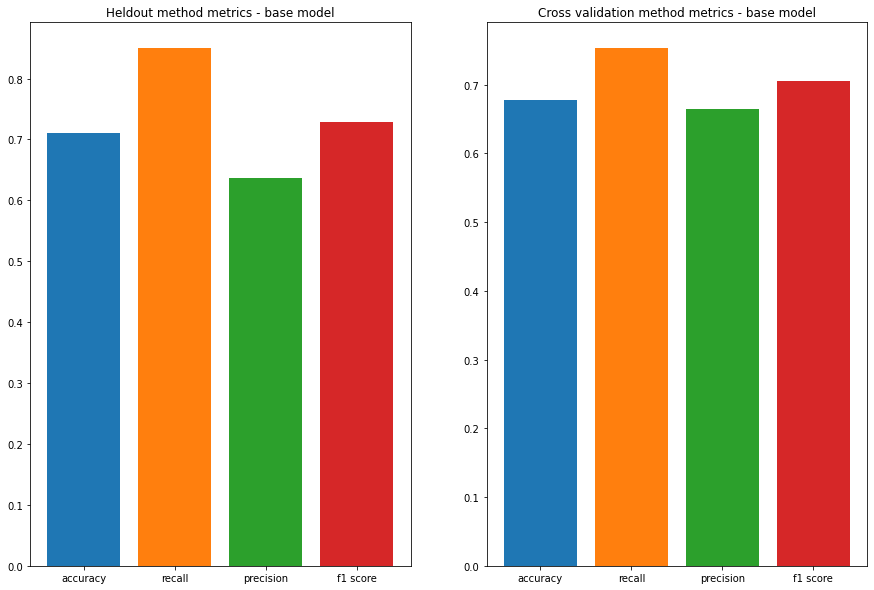

In [ ]:
draw_figure_metrics(f1_heldout, accuracy_heldout, recall_heldout, precision_heldout,
                    f1_cv, accuracy_cv, recall_cv, precision_cv)

We can see that the metrics are proportional for both methods. But are a bit higher for the heldout method.

Now, let's inspect the correlation

<h3>Inspecting Correlated Variables</h3>

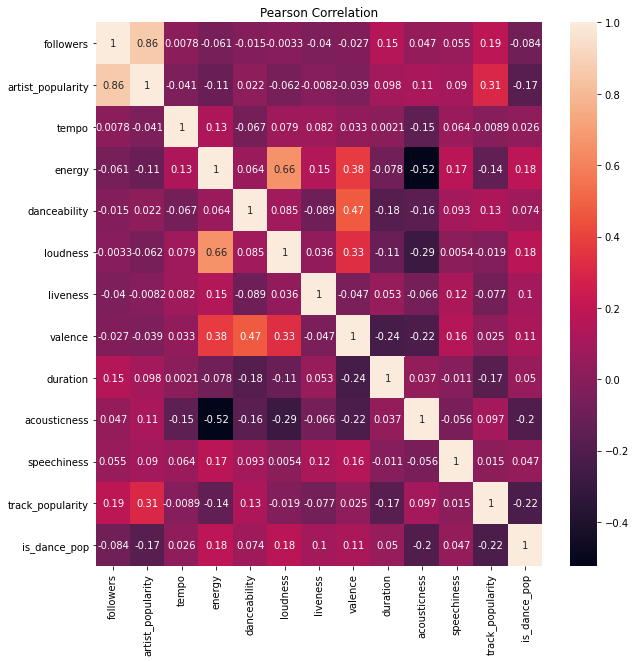

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation')
plt.show()

It is evident that artist popularity and followers have a high positive correlation of 0.86. We need to keep one of the attributes. Since artist_popularity is a bit more correlated with the target, I decided to drop followers. Additionally, energy and loudness have a high positive correlation of 0.66 and energy and acousticness have a negative correlation of -0.52. For this reason, I decide to drop energy, since it provides a lot of the same information with these other two variables. The other variables remain the same.

In [ ]:
data_not_correlated = data.drop(['followers', 'energy'], axis=1)

The new correlation matrix:

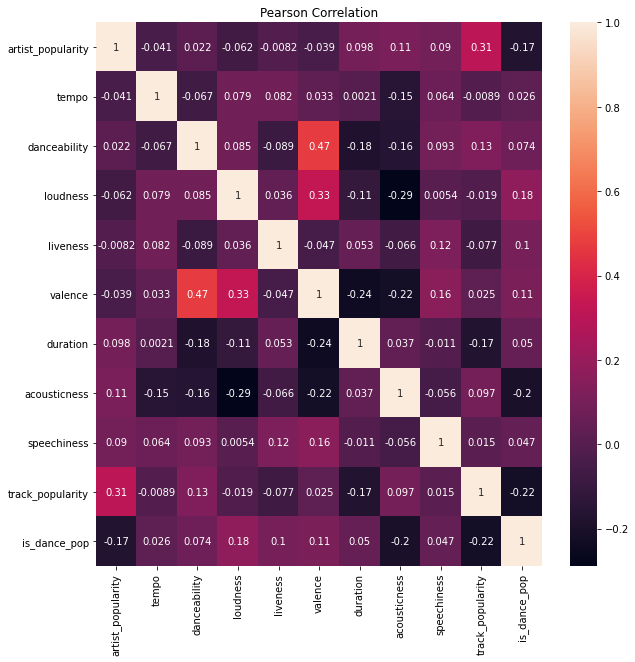

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data_not_correlated[data_not_correlated.columns.drop(['artist', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation')
plt.show()

Now the highest correlation is 0.47 between danceability and valence, but i decide to keep them both.

Now let's try the base model on these features

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data_not_correlated.drop(['is_dance_pop'], axis=1),
    data_not_correlated['is_dance_pop'],
    test_size=0.2,
    random_state=0
)

In [ ]:
nb_classifier.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_predicted_removed_corr = nb_classifier.predict(X_test)

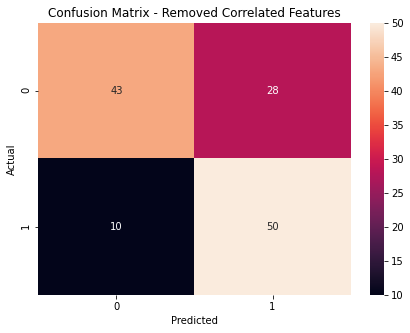

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, y_predicted_removed_corr), annot=True)
plt.title('Confusion Matrix - Removed Correlated Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

There is a minimal improvement, but it is insignificant.

Let's see for the full data set with cross_validation

In [ ]:
predicted, actual, scores_cv = cross_validation_nb(data_not_correlated.drop(['is_dance_pop'],axis=1), data_not_correlated['is_dance_pop'], nb_classifier)

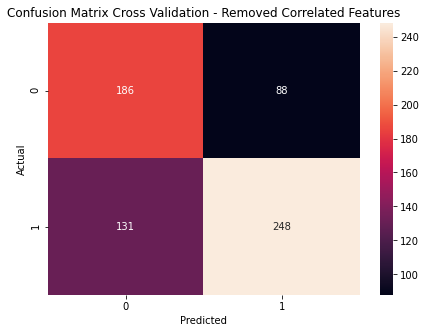

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted, actual), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Removed Correlated Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The cross validation score is almost the same as before


In [ ]:
scores_cv

array([0.53435115, 0.69465649, 0.70229008, 0.72307692, 0.63076923])

In [ ]:
scores_cv.mean()

0.6570287727539637

In [ ]:
f1_heldout = f1_score(Y_test, y_predicted_removed_corr)
accuracy_heldout = accuracy_score(Y_test, y_predicted_removed_corr)
precision_heldout = precision_score(Y_test, y_predicted_removed_corr)
recall_heldout = recall_score(Y_test, y_predicted_removed_corr)
######
f1_cv = f1_score(actual, predicted)
accuracy_cv = accuracy_score(actual, predicted)
precision_cv = precision_score(actual, predicted)
recall_cv = recall_score(actual, predicted)

In [ ]:
print(f'F1_score heldout: {f1_heldout}')
print(f'Accuracy heldout: {accuracy_heldout}')
print(f'Precision heldout: {precision_heldout}')
print(f'Recall heldout: {recall_heldout}')
print('------------------------------------')
print(f'F1_score cv: {f1_cv}')
print(f'Accuracy cv: {accuracy_cv}')
print(f'Precision cv: {precision_cv}')
print(f'Recall cv: {recall_cv}')

F1_score heldout: 0.7246376811594204
Accuracy heldout: 0.7099236641221374
Precision heldout: 0.6410256410256411
Recall heldout: 0.8333333333333334
------------------------------------
F1_score cv: 0.6937062937062938
Accuracy cv: 0.664624808575804
Precision cv: 0.6543535620052771
Recall cv: 0.7380952380952381


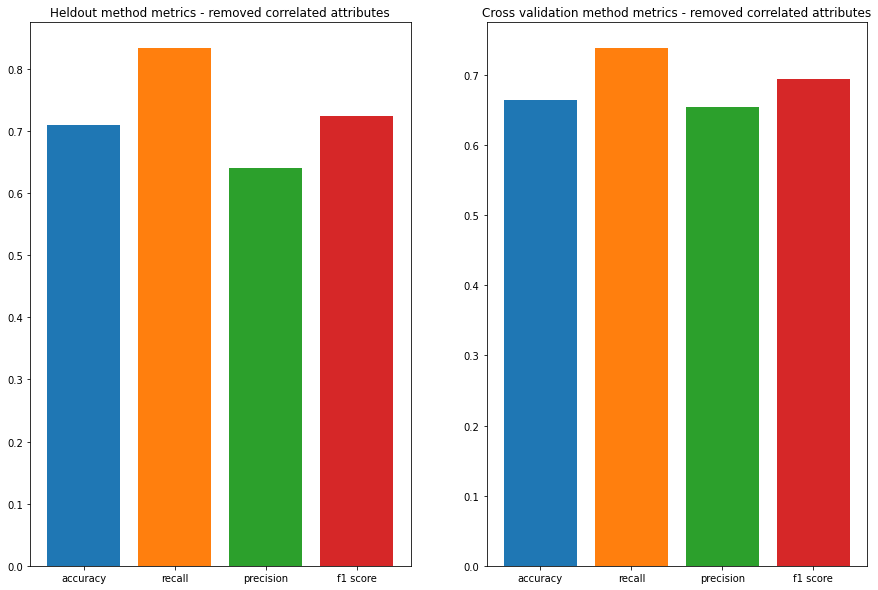

In [ ]:
draw_figure_metrics(f1_heldout, accuracy_heldout, recall_heldout, precision_heldout,
                    f1_cv, accuracy_cv, recall_cv, precision_cv, 'removed correlated attributes')

<h3>Comparison of performance with/without correlated attributes with 0.5 prior<h3>

<pre>Since the class distribution in the data set is [   0   1   ]
                                                [ 0.49 0.51 ]
We may assume a fair prior distribution.<pre>                                               

In [ ]:
nb_prior = GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-5)

In [ ]:
predicted_full, actual_full, scores_cv_full = cross_validation_nb(data.drop(['is_dance_pop'],axis=1), data['is_dance_pop'], nb_prior)

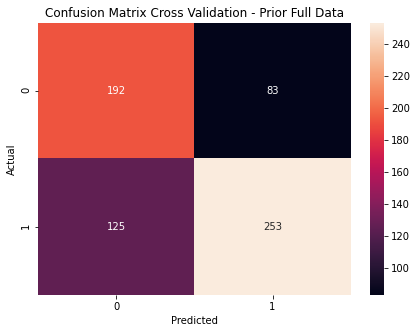

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted_full, actual_full), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Prior Full Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Not much improvement from before by adding a prior.

In [ ]:
scores_cv_full.mean()

0.6723546682325308

In [ ]:
predicted_rem, actual_rem, scores_cv_rem = cross_validation_nb(data_not_correlated.drop(['is_dance_pop'],axis=1), data_not_correlated['is_dance_pop'], nb_prior)

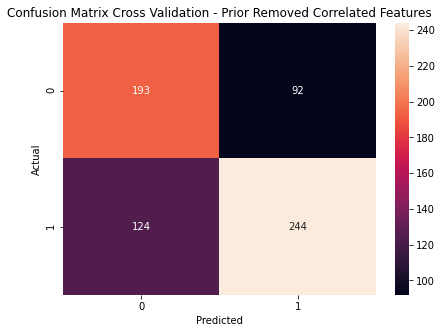

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted_rem, actual_rem), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Prior Removed Correlated Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The performance of the data with removed correlated features and 0.5 prior for each class is a bit worse.

In [ ]:
scores_cv_rem.mean()

0.6555020551967117

In [ ]:
f1_full= f1_score(actual_full, predicted_full)
accuracy_full = accuracy_score(actual_full, predicted_full)
precision_full = precision_score(actual_full, predicted_full)
recall_full = recall_score(actual_full, predicted_full)
######
f1_rem = f1_score(actual_rem, predicted_rem)
accuracy_rem = accuracy_score(actual_rem, predicted_rem)
precision_rem = precision_score(actual_rem, predicted_rem)
recall_rem = recall_score(actual_rem, predicted_rem)

In [ ]:
print(f'F1_score full data: {f1_full}')
print(f'Accuracy full data: {accuracy_full}')
print(f'Precision full data: {precision_full}')
print(f'Recall full data: {recall_full}')
print('------------------------------------')
print(f'F1_score removed correlated features: {f1_rem}')
print(f'Accuracy removed correlated features: {accuracy_rem}')
print(f'Precision removed correlated features: {precision_rem}')
print(f'Recall removed correlated features: {recall_rem}')

F1_score full data: 0.7086834733893557
Accuracy full data: 0.6814701378254211
Precision full data: 0.6693121693121693
Recall full data: 0.7529761904761905
------------------------------------
F1_score removed correlated features: 0.6931818181818181
Accuracy removed correlated features: 0.669218989280245
Precision removed correlated features: 0.6630434782608695
Recall removed correlated features: 0.7261904761904762


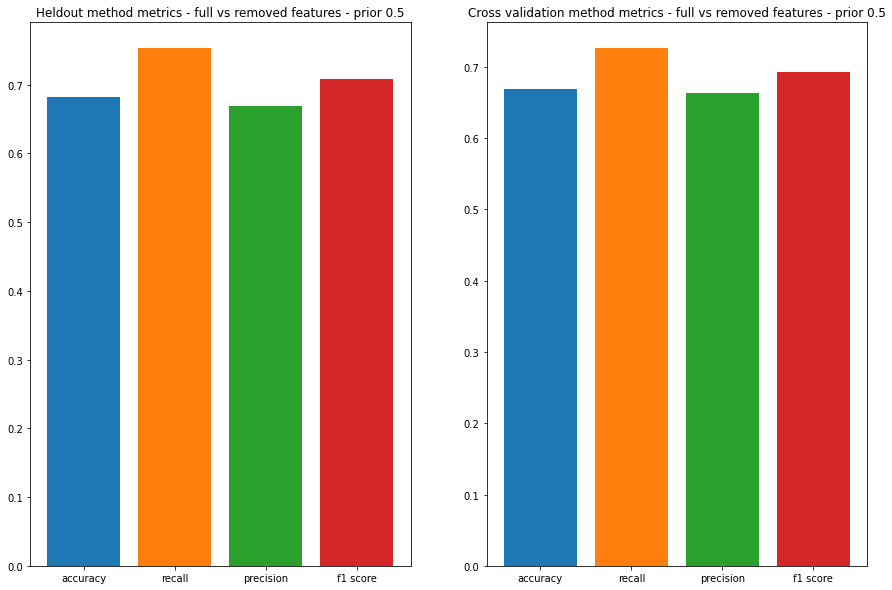

In [ ]:
draw_figure_metrics(f1_full, accuracy_full, recall_full, precision_full,
                    f1_rem, accuracy_rem, recall_rem, precision_rem, 'full vs removed features - prior 0.5')

Generally, the performance did not improve when a prior was added, nor when correlated features were removed. It did not improve with applying the two techniques together. The best F1 score achieved with cross validation for Bayesian Classifier was approximately 0.7 on the original data set and no prior.

<h3>Bayesian Belief Network<h3>

In [ ]:
!pip install pomegranate

In [ ]:
from pomegranate import BayesianNetwork

In [ ]:
net = BayesianNetwork.from_samples(data, state_names=data.columns, algorithm='chow-liu')

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main

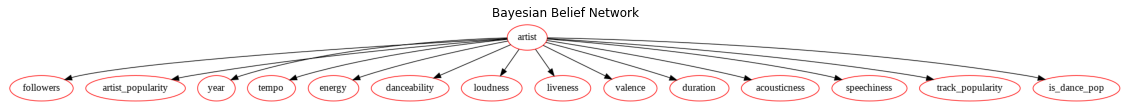

In [ ]:
plt.figure(figsize=(20,20))
net.plot()
plt.title('Bayesian Belief Network')
plt.show()

The netowrk suggest conditional dependence of the target variable is_dance_pop to the artist, which is reasonable since artists only make tracks from a few (or one) specific genres. All of the other attributes of the track depend on the artist. This is reasonable since artists make similar music occasionally.